In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.constant import PROCESSED_DATA_DIR

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

https://chatgpt.com/c/6806805f-6db8-8010-a13f-2f9f691c7921

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
from src.evaluation import evaluate_model_with_cross_validation
from src.split import permutate_df_by_cost_decreasing
from src.split import get_n_splits

In [197]:
train_idx, test_idx = get_n_splits(df, n=2, instance_number=5, solver_number=100, random_state=0)[0]

df_train = df.loc[train_idx]
df_test = df.loc[test_idx]

not_train_cols = ["solver_id", "instance_id", "generator", "cost"]

X_train = df_train.drop(columns=not_train_cols)
y_train = df_train["cost"].to_numpy()

X_test = df_test.drop(columns=not_train_cols)
y_test = df_test["cost"].to_numpy()
y_test_not_censored = y_test.copy()

const_cut_off = 1.0

cut_off_train = np.full(X_train.shape[0], const_cut_off)
cut_off_test = np.full(X_test.shape[0], const_cut_off)

y_train = np.clip(y_train, 0, cut_off_train)
y_test = np.clip(y_test, 0, cut_off_test)

y = np.log(y_train + 0.01)
cut_off = np.log(cut_off_train + 0.01)

In [198]:
from scipy.stats import norm

def truncated_normal_mean(mu, sigma, C):
    mu = np.asarray(mu, dtype=np.float_)
    sigma = np.asarray(sigma, dtype=np.float_)
    C = np.asarray(C, dtype=np.float_)
    result = np.empty_like(mu)

    # Where sigma > 0, compute normal truncated mean
    mask = sigma > 0
    alpha = (C[mask] - mu[mask]) / sigma[mask]
    result[mask] = mu[mask] + sigma[mask] * norm.pdf(alpha) / (1 - norm.cdf(alpha))

    # Where sigma == 0
    result[~mask] = np.maximum(mu[~mask], C[~mask])
    return result

truncated_normal_mean(1, 1, 1)

array(1.79788456)

In [199]:
from quantile_forest import RandomForestQuantileRegressor

In [ ]:
# implementation of the Schmee & Hahn imputation method

quantiles = np.linspace(0.01, 0.99, 99).tolist()
not_censored = y < cut_off

qrf = RandomForestQuantileRegressor(random_state=0)
qrf.fit(X_train[not_censored], y[not_censored])

y_imputed = y.copy()

for i in range(3):
    Y_pred = qrf.predict(X_train[~not_censored], quantiles=quantiles)
    y_pred_mean = Y_pred.mean(axis=1)
    y_pred_std = (Y_pred[:, 83] - Y_pred[:, 15]) / 2
    y_imputed[~not_censored] = truncated_normal_mean(y_pred_mean, y_pred_std, cut_off[~not_censored])

    qrf = RandomForestQuantileRegressor(random_state=0)
    qrf.fit(X_train, y_imputed)

C:\Users\grzegorzzakrzewski\AppData\Local\Temp\ipykernel_23096\4221914771.py:12: RuntimeWarning: divide by zero encountered in divide
  result[mask] = mu[mask] + sigma[mask] * norm.pdf(alpha) / (1 - norm.cdf(alpha))


ValueError: Input y contains infinity or a value too large for dtype('float64').

array([inf])

In [245]:
mu = -0.03119384
std = 0.00297261
C = 0.00995033

alpha = (C - mu) / std


1 - norm.cdf(alpha)

# mu + std * norm.pdf(alpha) / (1 - norm.cdf(alpha))

0.0

In [233]:
y_pred_std[y_imputed[~not_censored] > 1000]

array([0.00297261])

In [234]:
y_pred_mean[y_imputed[~not_censored] > 1000]

array([-0.03119384])

In [236]:
cut_off[y_imputed > 1000]

array([0.00995033])

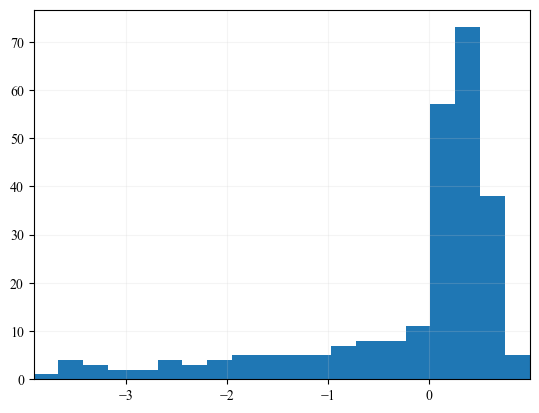

In [ ]:
plt.hist(y_imputed, bins=20);